In [1]:
import evals
from tensorflow import keras
import tensorflow as tf
import IJB_evals
import matplotlib.pyplot as plt
import keras_cv_attention_models
import GhostFaceNets, GhostFaceNets_with_Bias
from models import NormDense, NormDenseVPL

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
custom_objects = {
    "NormDense": NormDense,
    "NormDenseVPL": NormDenseVPL
}

model_path = 'base_model_no_changes_5k_images/ghostnetv1_w1.3_s2_basic_model_latest.h5'
model = keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [4]:
import numpy as np
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from keras.utils import load_img, img_to_array
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt


def generate_embedding(model, img_path):
    img = load_img(img_path, target_size=(112, 112))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    embedding = model.predict(img_array)
    return embedding

In [ ]:

image_folder = 'datasets/faces_emore_112x112_folders'
embeddings = []
images = []

for i in range(8000, 8600):
    subfolder_path = os.path.join(image_folder, str(i))
    if os.path.isdir(subfolder_path):
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)
            embedding = generate_embedding(model, img_path)  # Generowanie embeddingu
            img = load_img(img_path, target_size=(112, 112))
            img_array = img_to_array(img) / 255.0
            embeddings.append(embedding)  # Dodanie embeddingu do listy
            images.append(img_array)      # Dodanie obrazu do listy
            print(img_path)

embeddings = np.array(embeddings).squeeze()  # Usuwamy dodatkowy wymiar z embeddingów
images = np.array(images)

np.save('embeddings_base_attacker.npy', embeddings)
np.save('images_base_attacker.npy', images)

In [ ]:
embeddings = np.load('embeddings_base_attacker.npy')
images = np.load('images_base_attacker.npy')

In [ ]:
embedding_dim = embeddings.shape[1]


def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=embedding_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())  # Dodatkowa warstwa UpSampling2D
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(embedding_dim,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(112, 112, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(112, 112, 3))
    validity = model(img)

    return Model(img, validity)


img_shape = (112, 112, 3)
optimizer = Adam(0.0002, 0.5)


discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


generator = build_generator()


z = Input(shape=(embedding_dim,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)

gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)



def train_gan(epochs, batch_size=128, save_interval=50):
    if not os.path.exists('gan_base'):
        os.makedirs('gan_base')
    
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        idx = np.random.randint(0, images.shape[0], half_batch)
        imgs = images[idx]
        noise = embeddings[np.random.randint(0, embeddings.shape[0], half_batch)]
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        noise = embeddings[np.random.randint(0, embeddings.shape[0], batch_size)]
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
        
        if epoch % save_interval == 0:
            save_imgs(epoch)
            save_model(generator, epoch)

def save_imgs(epoch):
    if not os.path.exists('gan_base'):
        os.makedirs('gan_base')
    
    r, c = 5, 5
    noise = embeddings[np.random.randint(0, embeddings.shape[0], r * c)]
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"gan_base/gan_images_{epoch}.png")
    plt.close()

def save_model(model, epoch):
    model.save(f"gan_base/generator_{epoch}.h5")


train_gan(epochs=60000, batch_size=32, save_interval=500)

1/1 [==============================] - 0s 276ms/step


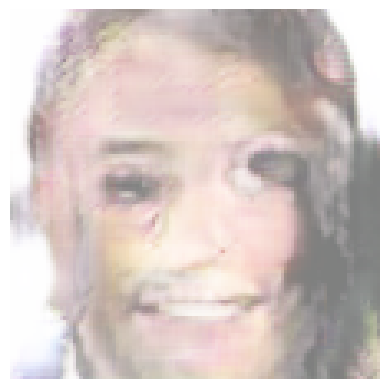

In [11]:
import numpy as np
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from keras.utils import load_img, img_to_array
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt


def generate_embedding(model, img_path):
    img = load_img(img_path, target_size=(112, 112))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    embedding = model.predict(img_array)
    return embedding
    

embedding = generate_embedding(model, 'datasets/test/0/1.jpg')
generator = load_model("gan_base_1/generator_59000.h5")
reconstructed_img = generator.predict(embedding)


plt.imshow(reconstructed_img[0] * 0.5 + 0.5)
plt.axis('off')
plt.show()
#plt.savefig("generated_stolen_1.png")

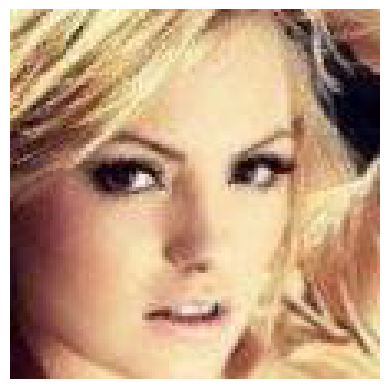

In [12]:
img_to_test = load_img('datasets/test/0/1.jpg', target_size=(112, 112))
plt.imshow(img_to_test)
plt.axis('off')
plt.show()
#plt.savefig("real_stolen_1.png")

1/1 [==============================] - 0s 27ms/step


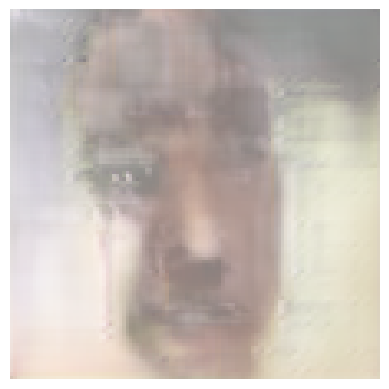

In [6]:

embedding2 = generate_embedding(model, 'datasets/faces_emore_112x112_folders/8072/553219.jpg')
reconstructed_img2 = generator.predict(embedding2)

plt.imshow(reconstructed_img2[0] * 0.5 + 0.5)
plt.axis('off')
plt.show()
#plt.savefig("generated_training_1.png")

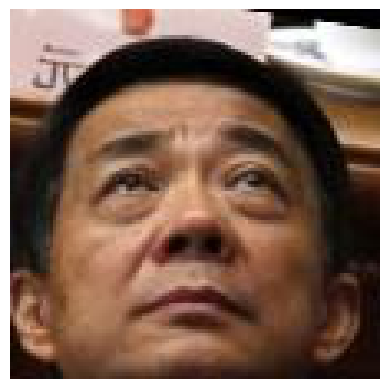

In [7]:
img_to_test2 = load_img('datasets/faces_emore_112x112_folders/8072/553219.jpg', target_size=(112, 112))
plt.imshow(img_to_test2)
plt.axis('off')
plt.show()
#plt.savefig("real_training_1.png")

In [13]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from PIL import Image

def mse(image1, image2):
    diff = image1 - image2
    squared_diff = np.square(diff)
    mse = np.mean(squared_diff)

    return mse

def compare_images(imageA, imageB):
    # Ensure the images have the same type
    imageA = imageA.astype(np.uint8)
    imageB = imageB.astype(np.uint8)
    
    # Calculate MSE
    m = mse(imageA, imageB)
    
    # Calculate SSIM
    s = ssim(imageA, imageB, multichannel=True)
    
    # Calculate PSNR
    p = cv2.PSNR(imageA, imageB)
    
    return m, s, p
    
# Convert PIL images to numpy arrays
imageA = np.array(reconstructed_img[0])
imageB = np.array(img_to_test)

# Compare the images
mse_value, ssim_value, psnr_value = compare_images(imageA, imageB)

print(f"MSE: {mse_value}")
print(f"SSIM: {ssim_value}")
print(f"PSNR: {psnr_value}")

MSE: 107.54318133503402
SSIM: 0.001024490966256785
PSNR: 3.6534166987944316


In [ ]:
image_folder = 'datasets/test'
embeddings = []
images = []

for i in range(50):
    subfolder_path = os.path.join(image_folder, str(i))
    if os.path.isdir(subfolder_path):
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)
            embedding = generate_embedding(model, img_path)
            img = load_img(img_path, target_size=(112, 112))
            embeddings.append(embedding)
            images.append(img)

mse_values = []
ssim_values = []
psnr_values = []

for i in range(len(images)):
    reconstructed_img = generator.predict(embeddings[i])
    # Convert PIL images to numpy arrays
    imageA = np.array(reconstructed_img[0])
    imageB = np.array(images[i])
    m, s, p = compare_images(imageA, imageB)
    #print(f"MSE: {m}")
    #print(f"SSIM: {s}")
    #print(f"PSNR: {p}")
    mse_values.append(m)
    ssim_values.append(s)
    psnr_values.append(p)


average_mse = np.mean(mse_values)
average_ssim = np.mean(ssim_values)
average_psnr = np.mean(psnr_values)

print(f"Average MSE: {average_mse}")
print(f"Average SSIM: {average_ssim}")
print(f"Average PSNR: {average_psnr}")

1/1 [==============================] - ETA: 0s

In [10]:
print(f"Average MSE: {average_mse}")
print(f"Average SSIM: {average_ssim}")
print(f"Average PSNR: {average_psnr}")

Average MSE: 103.80056554356865
Average SSIM: 0.015007701746783604
Average PSNR: 6.075132479383015
